In [1]:
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import warnings
warnings.filterwarnings('ignore')
import time
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("TensorFlow Version: ", tf.__version__)
print("CUDA Version: ", tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version:  2.15.0
CUDA Version:  True


### VGG1 Model

In [4]:
def VGG1():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.001, momentum=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### VGG2 Model

In [5]:
def VGG2():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.005, momentum=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



### VGG3 Model

In [50]:

def VGG3():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### VGG16 Model

*With tuning all the layers*

In [7]:
def vgg16():
    model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    for layer in model_vgg16.layers:
        layer.trainable = True
    x = Flatten()(model_vgg16.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=model_vgg16.inputs, outputs=x)
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

*With tuning only the MLP layers*

In [8]:
def vgg16_MLP():
    model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    for layer in model_vgg16.layers:
        layer.trainable = False
    x = Flatten()(model_vgg16.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=model_vgg16.inputs, outputs=x)
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MLP

In [9]:
def MLP():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def train(model, train_dir, test_dir, name, max_epochs=20):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    train_steps_per_epoch = len(train_it)
    test_steps_per_epoch = len(test_it)
    print(f"Train steps: {train_steps_per_epoch}, Test steps: {test_steps_per_epoch}")
    history = {'epoch_train_loss': [], 'epoch_train_accuracy': [], 'epoch_val_loss': [], 'epoch_val_accuracy': [],
                'iter_train_loss': [], 'iter_train_accuracy': [], 'iter_val_loss': [], 'iter_val_accuracy': []}
    writer = tf.summary.create_file_writer(f"logs/{name}")
    step = 0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch + 1}/{max_epochs}:")
        epoch_loss = []
        epoch_accuracy = []
        epoch_val_loss = []
        epoch_val_accuracy = []

        for batch_index in range(train_steps_per_epoch):
            X_batch, y_batch = next(train_it)
            loss, accuracy = model.train_on_batch(X_batch, y_batch)

            epoch_loss.append(loss)
            epoch_accuracy.append(accuracy)

            history['iter_train_loss'].append(loss)
            history['iter_train_accuracy'].append(accuracy)

            loss_val,acc_val=model.evaluate(test_it,steps=test_steps_per_epoch,verbose=0)
            epoch_val_loss.append(loss_val)
            epoch_val_accuracy.append(acc_val)
            history['iter_val_loss'].append(loss_val)
            history['iter_val_accuracy'].append(acc_val)
            with writer.as_default():
                tf.summary.scalar('Testing loss', loss_val, step=step)
                tf.summary.scalar('Testing accuracy', acc_val, step=step)
                tf.summary.scalar('Training loss', loss, step=step)
                tf.summary.scalar('Training accuracy', accuracy, step=step)
                writer.flush()
            step+=1

        avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss)
        avg_val_accuracy = sum(epoch_val_accuracy) / len(epoch_val_accuracy)
        avg_train_loss = sum(epoch_loss) / len(epoch_loss)
        avg_train_accuracy = sum(epoch_accuracy) / len(epoch_accuracy)
        history['epoch_train_loss'].append(avg_train_loss)
        history['epoch_train_accuracy'].append(avg_train_accuracy)
        history['epoch_val_loss'].append(avg_val_loss)
        history['epoch_val_accuracy'].append(avg_val_accuracy)

    return history

In [11]:
def train_augmentation(model,train_dir, test_dir,name, max_epochs=20):
    datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    train_steps_per_epoch = len(train_it)
    test_steps_per_epoch = len(test_it)
    print(f"Train steps: {train_steps_per_epoch}, Test steps: {test_steps_per_epoch}")
    history = {'epoch_train_loss': [], 'epoch_train_accuracy': [], 'epoch_val_loss': [], 'epoch_val_accuracy': [],
                'iter_train_loss': [], 'iter_train_accuracy': [], 'iter_val_loss': [], 'iter_val_accuracy': []}
    writer = tf.summary.create_file_writer(f"logs/{name}")
    step = 0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch + 1}/{max_epochs}:")
        epoch_loss = []
        epoch_accuracy = []
        epoch_val_loss = []
        epoch_val_accuracy = []

        for batch_index in range(train_steps_per_epoch):
            X_batch, y_batch = next(train_it)
            loss, accuracy = model.train_on_batch(X_batch, y_batch)

            epoch_loss.append(loss)
            epoch_accuracy.append(accuracy)

            history['iter_train_loss'].append(loss)
            history['iter_train_accuracy'].append(accuracy)

            loss_val,acc_val=model.evaluate(test_it,steps=test_steps_per_epoch,verbose=0)
            epoch_val_loss.append(loss_val)
            epoch_val_accuracy.append(acc_val)
            history['iter_val_loss'].append(loss_val)
            history['iter_val_accuracy'].append(acc_val)
            with writer.as_default():
                tf.summary.scalar('Testing loss', loss_val, step=step)
                tf.summary.scalar('Testing accuracy', acc_val, step=step)
                tf.summary.scalar('Training loss', loss, step=step)
                tf.summary.scalar('Training accuracy', accuracy, step=step)
                writer.flush()
            step+=1

        avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss)
        avg_val_accuracy = sum(epoch_val_accuracy) / len(epoch_val_accuracy)
        avg_train_loss = sum(epoch_loss) / len(epoch_loss)
        avg_train_accuracy = sum(epoch_accuracy) / len(epoch_accuracy)
        history['epoch_train_loss'].append(avg_train_loss)
        history['epoch_train_accuracy'].append(avg_train_accuracy)
        history['epoch_val_loss'].append(avg_val_loss)
        history['epoch_val_accuracy'].append(avg_val_accuracy)

    return history

In [12]:
def test(model,test_dir):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=2)
    print(f'Accuracy: {acc*100}')
    return acc*100

In [13]:
def summarize_diagnostics(history,txt):
    plt.figure(figsize=(8,4))
    plt.title(txt + 'Cross Entropy Loss')
    plt.plot(history['epoch_train_loss'], color='blue', label='train')
    plt.plot(history['epoch_val_loss'], color='orange', label='test')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    plt.savefig(txt + '_loss_plot.png')

    plt.figure(figsize=(8,4))
    plt.title(txt + 'Classification Accuracy')
    plt.plot(history['epoch_train_accuracy'], color='blue', label='train')
    plt.plot(history['epoch_val_accuracy'], color='orange', label='test')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    plt.savefig(txt + '_accuracy_plot.png')

In [14]:
def parameters(model):
    print(model.summary())
    return model.count_params()

In [15]:
import io
from matplotlib import pyplot
from skimage.transform import resize
def plot_to_image(figure):
    buf = io.BytesIO()
    pyplot.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    pyplot.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def image_grid(predictions, images):
    figure = pyplot.figure(figsize=(10, 10))
    num_images = len(images)
    permutation = np.random.permutation(num_images)

    # Shuffle images and predictions based on the permutation
    shuffled_images = [images[i] for i in permutation]
    shuffled_predictions = [predictions[i] for i in permutation]
    for i in range(40):
        # Start next subplot.
        pyplot.subplot(5, 8, i + 1, title= 'Bear' if shuffled_predictions[i] < 0.5 else 'Koala')
        pyplot.xticks([])
        pyplot.yticks([])
        pyplot.grid(False)
        # Resize the image to 200x200 pixels before displaying it
        # resized_image = resize(shuffled_images[i], (200, 200))
        pyplot.imshow(shuffled_images[i])

    return figure

def load_image(filename):
     # load the image
    img = load_img(filename, target_size=(200, 200))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 200, 200, 3)
    # center pixel data
    img = img.astype('float32')
    # img = img - [123.68, 116.779, 103.939]
    return img

In [16]:
def write_image(model, test_images, images, name):
    file_writer = tf.summary.create_file_writer(f"logs/{name}/test_images")
    predictions = []
    for i in test_images:
        prediction = model.predict(i)            #i has shape (1,200,200,3)
        predictions.append(prediction[0][0])

    figure = image_grid(predictions, images)

    with file_writer.as_default():
        tf.summary.image("Test Image", plot_to_image(figure), step=0)

In [17]:
# Create test_images
test_images = []
images = []
# load test_images from /content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/koala
for file in os.listdir('/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/koala/'):
    img= load_image('/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/koala/' + file)
    images.append(Image.open('/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/koala/' + file))
    test_images.append(img)


for file in os.listdir('/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/bear/'):
    img= load_image('/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/bear/' + file)
    images.append(Image.open('/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test/bear/' + file))
    test_images.append(img)

In [ ]:
print(test_images)

#### *VGG1*

In [18]:
vgg1 = VGG1()
params_vgg1 = parameters(vgg1)
print(f"Total Parameters in VGG1: {params_vgg1}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 128)               40960128  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 40961153 (156.25 MB)
Trainable params: 40961153 (156.25 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [19]:
start_time = time.time()
history_vgg1 = train(vgg1,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg1')
end_time = time.time()
time_vgg1 = end_time - start_time
print(f'Time taken for VGG1: {time_vgg1}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for VGG1: 267.11824464797974


In [20]:
write_image(vgg1, test_images, images, 'vgg1')

1/1 [==============================] - 0s 17ms/step


In [21]:
training_loss_vgg1, training_accuracy_vgg1 = history_vgg1['epoch_train_loss'][-1], history_vgg1['epoch_train_accuracy'][-1]

In [22]:
training_loss_vgg1, training_accuracy_vgg1

(0.4284502938389778, 0.8187500089406967)

Found 40 images belonging to 2 classes.
1/1 - 1s - loss: 0.4534 - accuracy: 0.7750 - 976ms/epoch - 976ms/step
Accuracy: 77.49999761581421


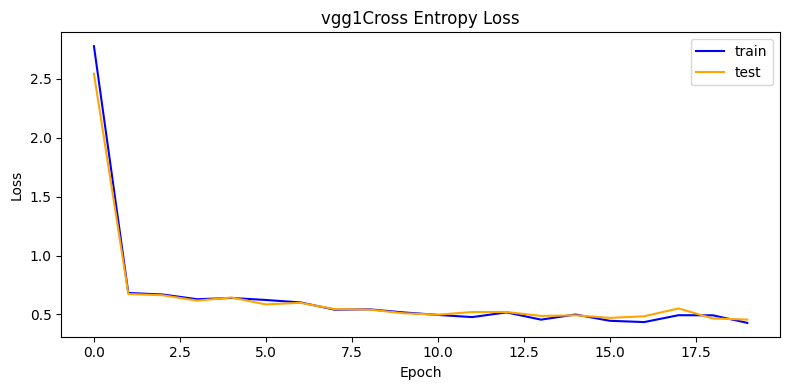

<Figure size 640x480 with 0 Axes>

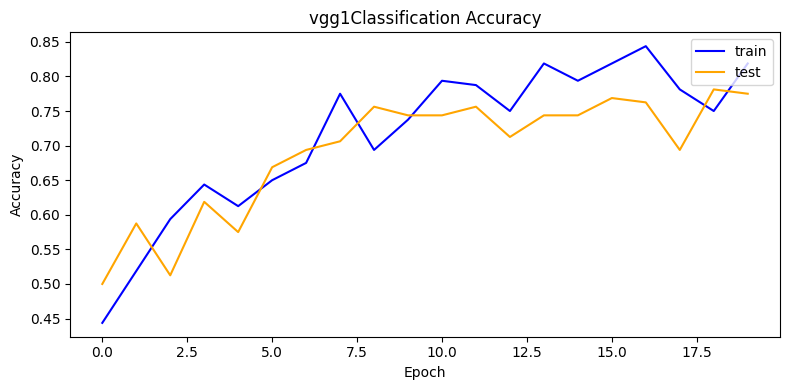

<Figure size 640x480 with 0 Axes>

In [23]:
start_time = time.time()
accuracy_vgg1 = test(vgg1, '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg1,'vgg1')

time_vgg1_test = end_time - start_time

#### *VGG2*

In [24]:
vgg2 = VGG2()
params_vgg2 = parameters(vgg2)
print(f"Total Parameters in VGG2: {params_vgg2}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 160000)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [25]:
start_time = time.time()
history_vgg2 = train(vgg2,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg2')
end_time = time.time()
time_vgg2 = end_time - start_time
print(f'Time taken for VGG2: {time_vgg2}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for VGG2: 265.4743559360504


In [26]:
training_loss_vgg2, training_accuracy_vgg2 = history_vgg2['epoch_train_loss'][-1], history_vgg2['epoch_train_accuracy'][-1]
training_loss_vgg2, training_accuracy_vgg2

(0.31812434270977974, 0.9000000059604645)

In [27]:
write_image(vgg2, test_images, images, 'vgg2')

1/1 [==============================] - 0s 61ms/step


Found 40 images belonging to 2 classes.
1/1 - 1s - loss: 0.3791 - accuracy: 0.8750 - 1s/epoch - 1s/step
Accuracy: 87.5


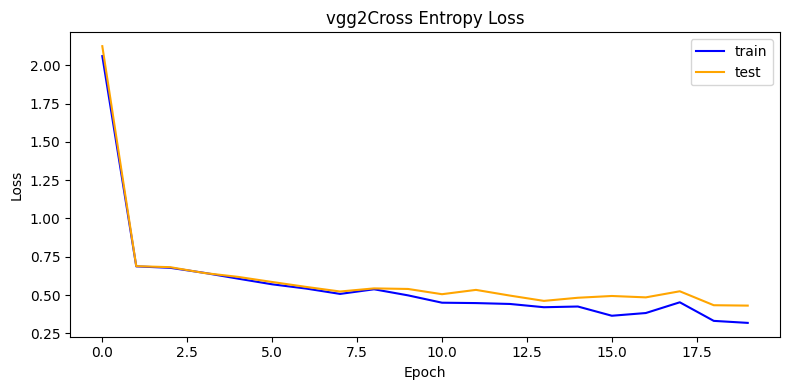

<Figure size 640x480 with 0 Axes>

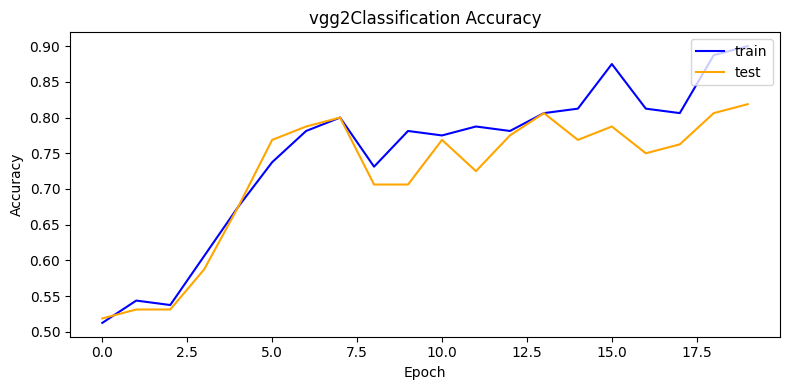

<Figure size 640x480 with 0 Axes>

In [28]:
start_time = time.time()
accuracy_vgg2 = test(vgg2,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg2,'vgg2')
time_vgg2_test = end_time - start_time

#### *VGG3*

In [35]:
vgg3 = VGG3()
params_vgg3 = parameters(vgg3)
print(f"Total Parameters in VGG3: {params_vgg3}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 25, 25, 128)      

In [36]:
start_time = time.time()
history_vgg3 = train(vgg3,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg3')
end_time = time.time()
time_vgg3 = end_time - start_time
print(f'Time taken for VGG3: {time_vgg3}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for VGG3: 264.30951833724976


In [71]:
write_image(vgg3,test_images, images, 'vgg3')

1/1 [==============================] - 0s 25ms/step


In [37]:
training_loss_vgg3, training_accuracy_vgg3 = history_vgg3['epoch_train_loss'][-1], history_vgg3['epoch_train_accuracy'][-1]
training_loss_vgg3, training_accuracy_vgg3

(0.3888365104794502, 0.8124999850988388)

Found 40 images belonging to 2 classes.
1/1 - 2s - loss: 0.4038 - accuracy: 0.8500 - 2s/epoch - 2s/step
Accuracy: 85.00000238418579


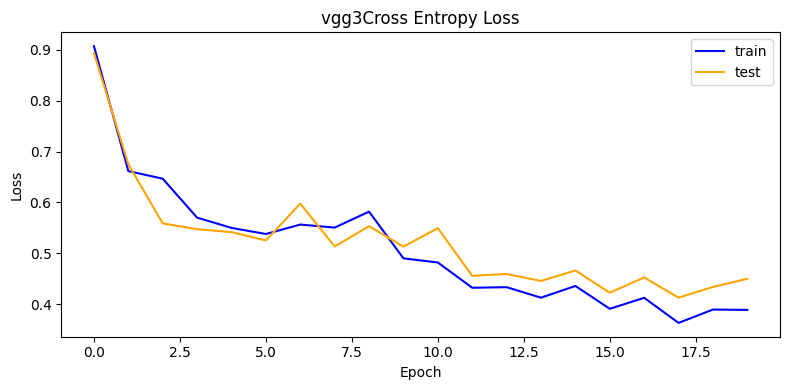

<Figure size 640x480 with 0 Axes>

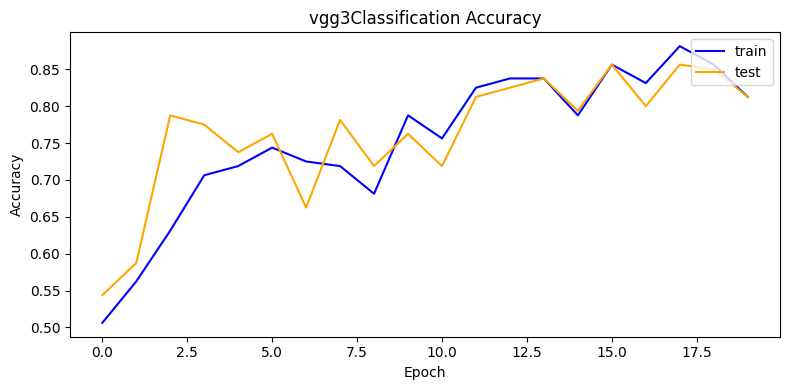

<Figure size 640x480 with 0 Axes>

In [38]:
start_time = time.time()
accuracy_vgg3 = test(vgg3,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg3,'vgg3')

time_vgg3_test = end_time - start_time

#### *VGG3 (with augmentation)*

In [51]:
vgg3_aug = VGG3()
params_vgg3_aug = parameters(vgg3_aug)
print(f"Total Parameters in VGG3 augmented data: {params_vgg3_aug}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 100, 100, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 50, 50, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 25, 25, 128)      

In [52]:
start_time = time.time()
history_vgg3_aug = train_augmentation(vgg3_aug,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg3_aug')
end_time = time.time()
time_vgg3_aug = end_time - start_time
print(f'Time taken for VGG3 with augmentation: {time_vgg3_aug}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for VGG3 with augmentation: 345.1303017139435


In [60]:
write_image(vgg3, test_images, images, 'vgg3_aug')

1/1 [==============================] - 0s 21ms/step


In [53]:
training_loss_vgg3_aug, training_accuracy_vgg3_aug = history_vgg3_aug['epoch_train_loss'][-1], history_vgg3_aug['epoch_train_accuracy'][-1]
training_loss_vgg3_aug, training_accuracy_vgg3_aug

(0.45702120661735535, 0.7812500149011612)

Found 40 images belonging to 2 classes.
1/1 - 1s - loss: 0.4388 - accuracy: 0.8500 - 968ms/epoch - 968ms/step
Accuracy: 85.00000238418579


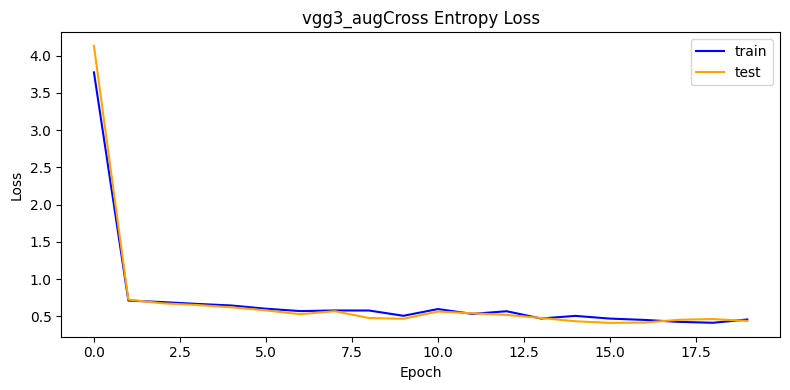

<Figure size 640x480 with 0 Axes>

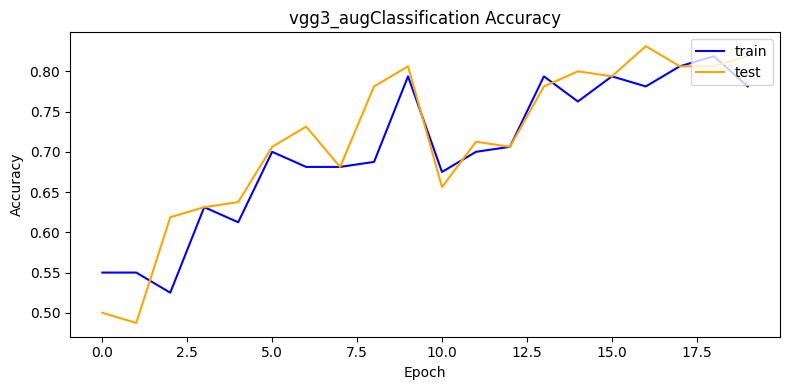

<Figure size 640x480 with 0 Axes>

In [54]:
start_time = time.time()
accuracy_vgg3_aug = test(vgg3_aug,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg3_aug,'vgg3_aug')

time_vgg3_aug_test = end_time - start_time

#### *VGG16 (with tunning all the layers)*

In [55]:
vgg16_all = vgg16()
params_vgg16_all = parameters(vgg16_all)
print(f"Total Parameters in VGG16: {params_vgg16_all}")

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [56]:
start_time = time.time()
history_vgg16 = train(vgg16_all,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg16_all')
end_time = time.time()
time_vgg16_all = end_time - start_time
print(f'Time taken for VGG16: {time_vgg16_all}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for VGG16: 337.6621901988983


In [57]:
write_image(vgg16_all, test_images, images, 'vgg16_all')

1/1 [==============================] - 0s 17ms/step


In [58]:
training_loss_vgg16_all, training_accuracy_vgg16_all = history_vgg16['epoch_train_loss'][-1], history_vgg16['epoch_train_accuracy'][-1]
training_loss_vgg16_all, training_accuracy_vgg16_all

(7.855147850932553e-05, 1.0)

Found 40 images belonging to 2 classes.
1/1 - 1s - loss: 0.0846 - accuracy: 0.9500 - 1s/epoch - 1s/step
Accuracy: 94.9999988079071


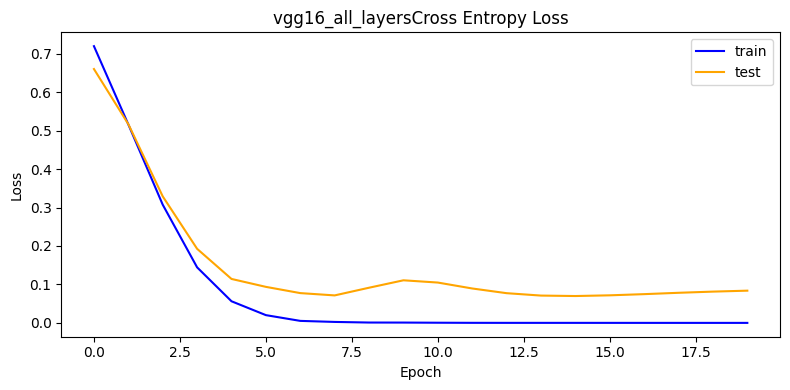

<Figure size 640x480 with 0 Axes>

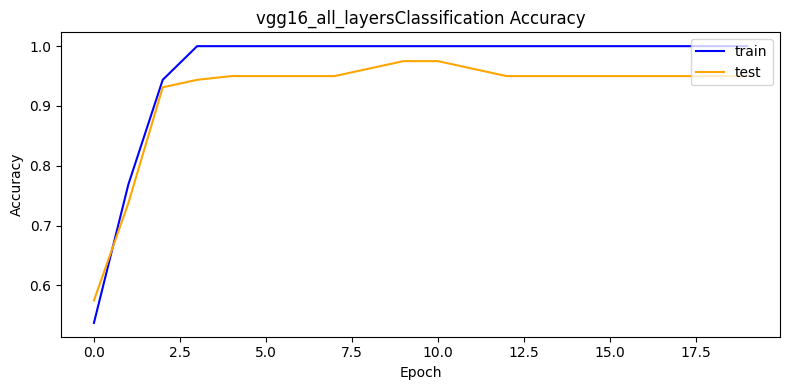

<Figure size 640x480 with 0 Axes>

In [59]:
start_time = time.time()
accuracy_vgg16_all = test(vgg16_all,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg16,'vgg16_all_layers')

time_vgg16_all_test = end_time - start_time

#### *VGG16 (with tunning only mlp layer)*

In [61]:
vgg16_mlp = vgg16_MLP()
params_vgg16_mlp = parameters(vgg16_mlp)
print(f"Total Parameters in VGG16 with MLP: {params_vgg16_mlp}")

# Tunable parameters
vgg16_mlp_trainable = 0
for layers in vgg16_mlp.layers[-2:]:
    vgg16_mlp_trainable += layers.count_params()
print(f"Parameters in VGG16 with MLP which are trainable: {vgg16_mlp_trainable}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [62]:
start_time = time.time()
history_vgg16_mlp = train(vgg16_mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg16_mlp')
end_time = time.time()
time_vgg16_mlp = end_time - start_time
print(f'Time taken for VGG16 with MLP: {time_vgg16_mlp}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for VGG16 with MLP: 297.8429274559021


In [63]:
write_image(vgg16_mlp, test_images, images, 'vgg16_mlp' )

1/1 [==============================] - 0s 16ms/step


In [64]:
training_loss_vgg16_mlp, training_accuracy_vgg16_mlp = history_vgg16_mlp['epoch_train_loss'][-1], history_vgg16_mlp['epoch_train_accuracy'][-1]
training_loss_vgg16_mlp, training_accuracy_vgg16_mlp

(0.054348756559193134, 1.0)

Found 40 images belonging to 2 classes.
1/1 - 2s - loss: 0.1545 - accuracy: 0.9500 - 2s/epoch - 2s/step
Accuracy: 94.9999988079071


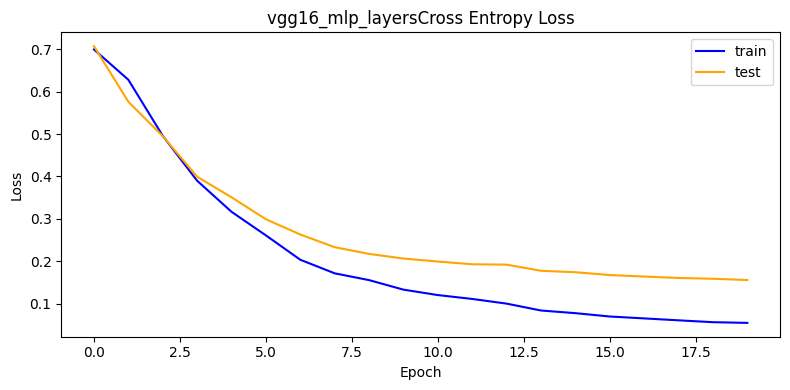

<Figure size 640x480 with 0 Axes>

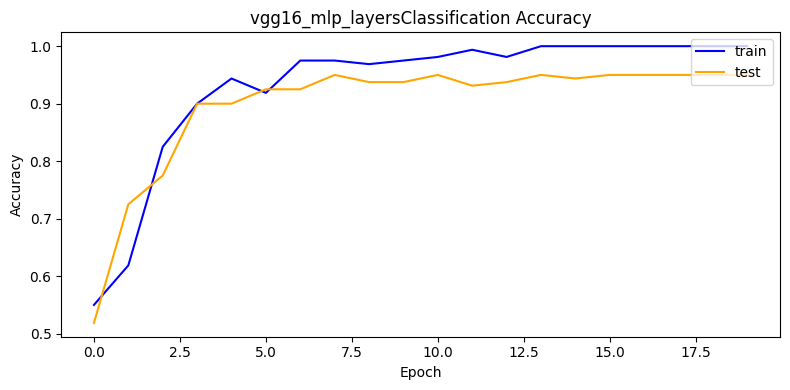

<Figure size 640x480 with 0 Axes>

In [65]:
start_time = time.time()
accuracy_vgg16_mlp = test(vgg16_mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg16_mlp,'vgg16_mlp_layers')

time_vgg16_mlp_test = end_time - start_time

In [66]:
mlp= MLP()
param_mlp = parameters(mlp)
print(f"Total Parameters in MLP model: {param_mlp}")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 120000)            0         
                                                                 
 dense_18 (Dense)            (None, 128)               15360128  
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 15360257 (58.59 MB)
Trainable params: 15360257 (58.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Total Parameters in MLP model: 15360257


In [67]:
start_time= time.time()
history_mlp = train(mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','mlp' )
end_time = time.time()
time_mlp= end_time - start_time
print(f'Time taken for MLP: {time_mlp}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Train steps: 4, Test steps: 1
Epoch 1/20:
Epoch 2/20:
Epoch 3/20:
Epoch 4/20:
Epoch 5/20:
Epoch 6/20:
Epoch 7/20:
Epoch 8/20:
Epoch 9/20:
Epoch 10/20:
Epoch 11/20:
Epoch 12/20:
Epoch 13/20:
Epoch 14/20:
Epoch 15/20:
Epoch 16/20:
Epoch 17/20:
Epoch 18/20:
Epoch 19/20:
Epoch 20/20:
Time taken for MLP: 275.5514988899231


In [68]:
write_image(mlp, test_images, images, 'mlp')

1/1 [==============================] - 0s 16ms/step


In [69]:
training_loss_mlp, training_accuracy_mlp = history_mlp['epoch_train_loss'][-1], history_mlp['epoch_train_accuracy'][-1]
training_loss_mlp, training_accuracy_mlp

(0.18288931995630264, 0.9812500029802322)

Found 40 images belonging to 2 classes.
1/1 - 1s - loss: 0.3879 - accuracy: 0.8000 - 1s/epoch - 1s/step
Accuracy: 80.0000011920929


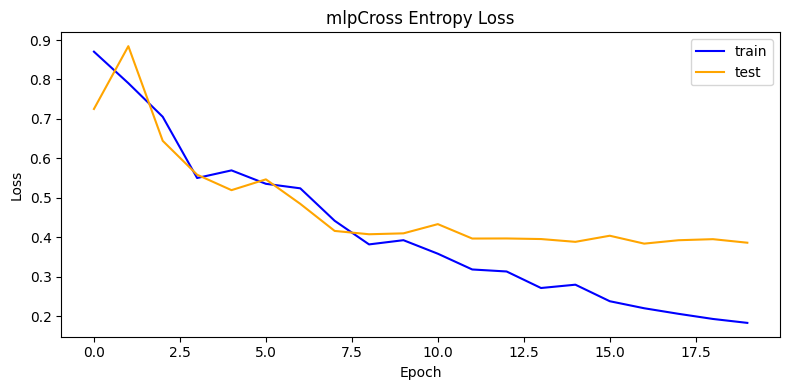

<Figure size 640x480 with 0 Axes>

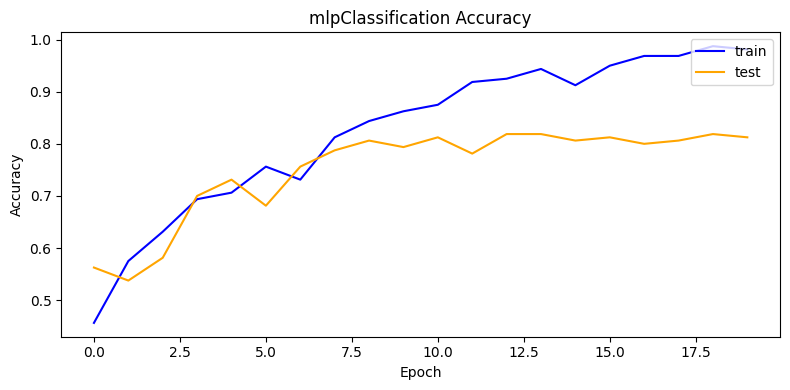

<Figure size 640x480 with 0 Axes>

In [70]:
start_time = time.time()
accuracy_mlp = test(mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_mlp,'mlp')

time_mlp_test = end_time - start_time

#### *Data Frame*

In [72]:
directory = 'dataframes'
if not os.path.exists(directory):
    os.makedirs(directory)


In [73]:
models = ['VGG1', 'VGG2', 'VGG3', 'VGG3 with Augmentation', 'VGG16 ', 'VGG16 (Tunning MLP)','mlp']
training_time = [time_vgg1,time_vgg2,time_vgg3,time_vgg3_aug,time_vgg16_all,time_vgg16_mlp,time_mlp]
accuracy_models = [accuracy_vgg1,accuracy_vgg2,accuracy_vgg3,accuracy_vgg3_aug,accuracy_vgg16_all,accuracy_vgg16_mlp, accuracy_mlp]
total_parameters = [params_vgg1,params_vgg2,params_vgg3,params_vgg3_aug,params_vgg16_all,params_vgg16_mlp, param_mlp]
training_loss = [training_loss_vgg1,training_loss_vgg2,training_loss_vgg3,training_loss_vgg3_aug,training_loss_vgg16_all,training_loss_vgg16_mlp, training_loss_mlp]
training_accuracy = [training_accuracy_vgg1,training_accuracy_vgg2,training_accuracy_vgg3,training_accuracy_vgg3_aug,training_accuracy_vgg16_all,training_accuracy_vgg16_mlp,training_accuracy_mlp ]
df = pd.DataFrame({'Models':models,'Total Parameters':total_parameters,'Training Time':training_time,'Training Loss':training_loss,'Training Accuracy':training_accuracy,'Test Accuracy':accuracy_models})
df.to_csv(directory + 'results.csv', index=False)
df

,Models,Total Parameters,Training Time,Training Loss,Training Accuracy,Test Accuracy
0,VGG1,40961153,267.118245,0.428450,0.81875,77.499998
1,VGG2,20499649,265.474356,0.318124,0.90000,87.500000
2,VGG3,10333505,264.309518,0.388837,0.81250,85.000002
3,VGG3 with Augmentation,10333505,345.130302,0.457021,0.78125,85.000002
4,VGG16,17074241,337.662190,0.000079,1.00000,94.999999
5,VGG16 (Tunning MLP),17074241,297.842927,0.054349,1.00000,94.999999
6,mlp,15360257,275.551499,0.182889,0.98125,80.000001
